<h1> 2 inputs : Numerical  and Categorical encoded separately

Upvote is free of charge :-))

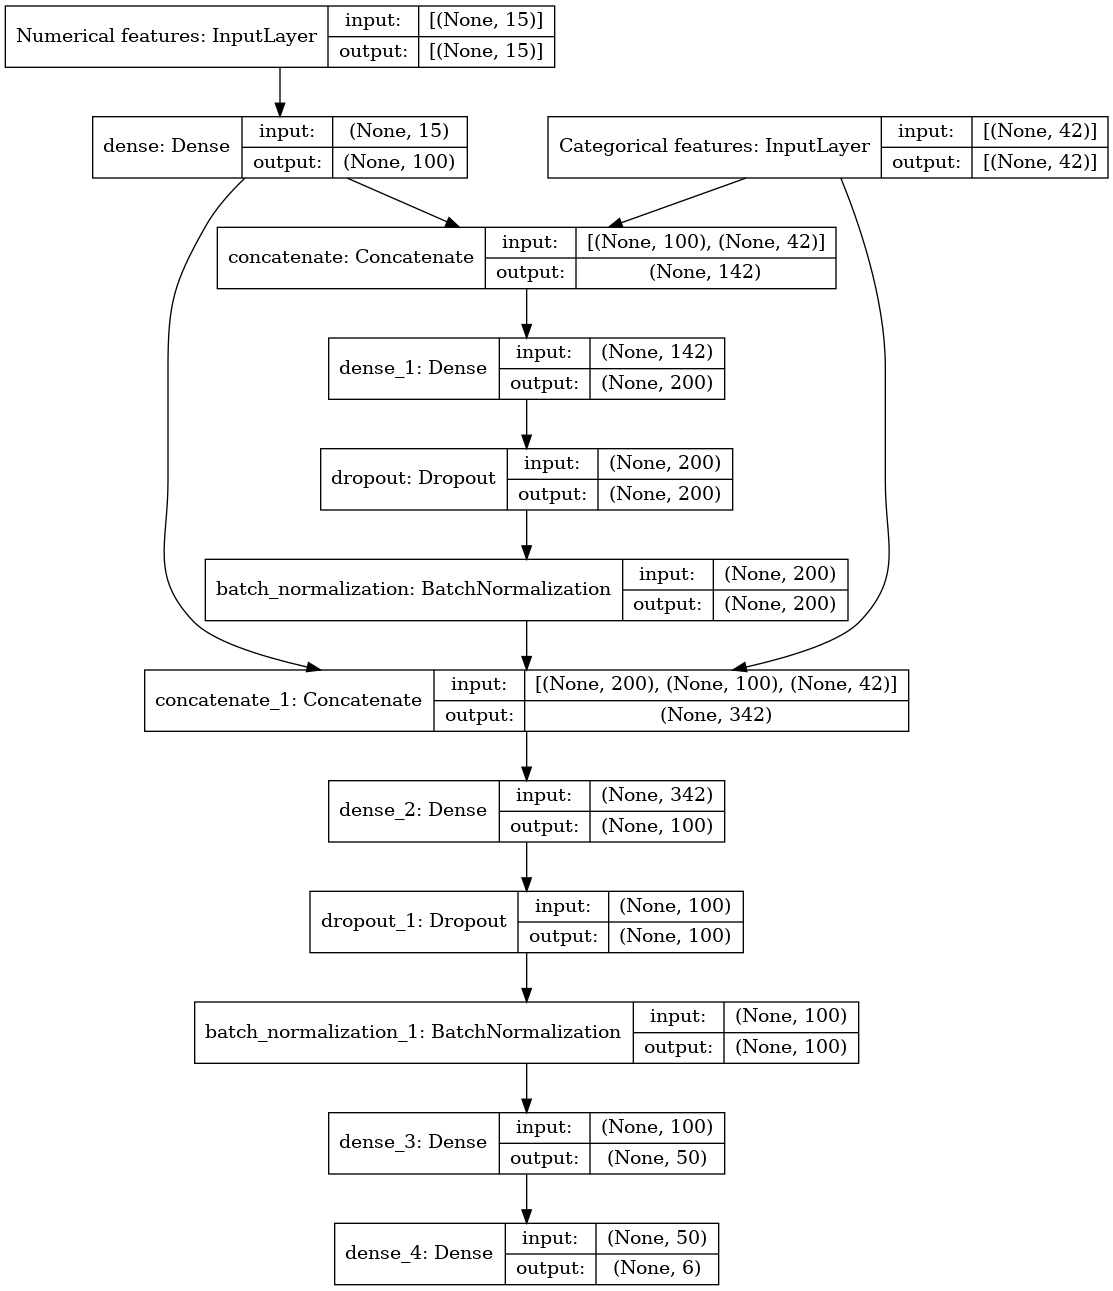

In [ ]:
import numpy as np 
import pandas as pd 
import gc

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Activation,  BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-dec-2021/train.csv').astype('float32')
test = pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv").astype('float32')
train.drop(['Soil_Type7','Soil_Type15'],axis =1, inplace = True)
test.drop(['Soil_Type7','Soil_Type15'],axis =1, inplace = True)
train.drop(labels =train[train.Cover_Type==5].index,axis = 0, inplace = True)
train = train.reset_index(drop=True)

<h2> Pseudo labelling

In [ ]:
pred  = pd.read_csv('../input/tps-december/submission.csv').astype('int')
pseudo_test = test.copy()
pseudo_test['Cover_Type'] = pred['Cover_Type']
pseudo_test.shape

In [ ]:
train = pd.concat([train,pseudo_test],axis=0)
train = train.reset_index(drop = True)
train.shape

In [ ]:
del pseudo_test
gc.collect()

In [ ]:
target = train['Cover_Type']
y = pd.get_dummies(train['Cover_Type'])
train.drop(['Cover_Type','Id'], axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)
train.shape, test.shape

In [ ]:
cat_col = [col for col in train.columns if train[col].nunique() < 4]
num_col = [col for col in train.columns if col not in cat_col]

<h2> Simple additional features

In [ ]:
train["mean"] = train[num_col].mean(axis=1)
train["std"] = train[num_col].std(axis=1)
train["min"] = train[num_col].min(axis=1)
train["max"] = train[num_col].max(axis=1)
train["skew"] = train[num_col].skew(axis=1)

test["mean"] = test[num_col].mean(axis=1)
test["std"] = test[num_col].std(axis=1)
test["min"] = test[num_col].min(axis=1)
test["max"] = test[num_col].max(axis=1)
test["skew"] =test[num_col].skew(axis=1)

<h2> Numerical and Categorical data split

In [ ]:
num_col = [col for col in train.columns if col not in cat_col]

train_num = train[num_col]
train_cat = train[cat_col]
test_num = test[num_col]
test_cat = test[cat_col]

In [ ]:
ss = StandardScaler()
train_num = pd.DataFrame(ss.fit_transform(train_num))
test_num = pd.DataFrame(ss.transform(test_num))

In [ ]:
#del train
gc.collect()

In [ ]:
run = 1 # number of training
number = 8 # number for files submission's name

BATCH_SIZE = 1024*5
EPOCH = 100

for j in range(run):
    
    # Init Values :
    pred_final = np.zeros((test_num.shape[0],6))
    N_split = [13,20] # for several runs, we can change the split, the seed,the drop...
    SEED = [1,1]
    DROP = [0.05,0.05]
    UNIT = [200,200]
    ACT = 'relu'
    KERNEL = tf.keras.initializers.GlorotNormal()
    number +=1
    train_run = np.zeros((y.shape[0],6))

    skf = StratifiedKFold(n_splits = N_split[j], random_state = SEED[j], shuffle = True)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_num, target)):
        
        # numerical split
        xtrain_num = train_num.iloc[train_idx,:]
        xtrain_cat = train_cat.iloc[train_idx,:]
        ytrain = y.loc[train_idx]
        
        # categorical split
        xval_num = train_num.iloc[val_idx,:]
        xval_cat = train_cat.iloc[val_idx,:]
        yval = y.loc[val_idx]

        # Inputs for NN model :

        input_cat= Input(
                shape = (train_cat.shape[1]),
                name = "Categorical features"
                )
        
        input_num = Input(
                shape = (train_num.shape[1]),
                name = "Numerical features"
                )

        # Numerical features encoding
        Y = Dense(UNIT[j]/2,
                kernel_initializer=KERNEL, 
                activation=ACT)(input_num)

        # Inputs Concatenation
        W = Concatenate()([Y,input_cat])
        W = Dense(UNIT[j],
                kernel_initializer=KERNEL, 
                activation=ACT)(W)
        W = Dropout(DROP[j])(W)
        W = BatchNormalization()(W)

        # Skip connection
        Z = Concatenate()([W,Y,input_cat])
        Z = Dense(UNIT[j]/2, 
                kernel_initializer=KERNEL, 
                activation=ACT)(Z)

        Z = Dropout(DROP[j])(Z)
        Z = BatchNormalization()(Z)

        Z= Dense(UNIT[j]/4, 
                kernel_initializer=KERNEL, 
                activation=ACT)(Z)
        output1 = Dense(6, 
                kernel_initializer=KERNEL,
                activation='softmax')(Z)

        model = Model(inputs = [input_num, input_cat],
                      outputs = output1,name = 'model')

        # Training control :
        es = tf.keras.callbacks.EarlyStopping(
                monitor = 'val_acc', 
                min_delta = 1e-06, 
                patience = 6, 
                verbose = 0,
                mode = 'max', 
                baseline = None,
                restore_best_weights = True)

        plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_acc',
                factor = 0.5,
                patience = 3,
                verbose = 0,
                mode = 'max')

        # Training :

        METRICS = ['acc']
        OPTIMIZER = keras.optimizers.Adam(learning_rate = 0.01)

        model.compile(
                loss = 'categorical_crossentropy',
                optimizer = OPTIMIZER,
                metrics = METRICS) 

        model.fit(
                [xtrain_num,xtrain_cat],
                ytrain,
                epochs = EPOCH,
                batch_size = BATCH_SIZE,
                validation_data = ([xval_num,
                                    xval_cat],
                                   yval),
                verbose = 0,
                callbacks=[es,plateau]
                )

        # NN prediction :
        pred = model.predict([xval_num,
                              xval_cat])
        train_run[val_idx,:] = pred

        y_val = np.argmax(np.array(yval), axis=1) + 1
        y_val = np.where(y_val < 5, y_val, y_val+1)
        pred1 = np.argmax(pred, axis=1) +1
        pred1 = np.where(pred1 < 5, pred1, pred1+1)

        print('FOLD = ',
              fold+1,
              "SCORE NN =",
              accuracy_score(y_val, pred1))

        pred_test = model.predict([test_num,test_cat])
        pred_final += pred_test/N_split[j]

    pred_train_final = np.argmax(train_run, axis = 1) +1
    pred_train_final = np.where(pred_train_final < 5, pred_train_final, pred_train_final + 1) 
    
    print('\n')
    print(65*'*')
    print('number =',
          number,
          "FOLD =",
          N_split[j],
          "Seed =",
          SEED[j],
          " SCORE =",
          accuracy_score(target, pred_train_final)) 
    print(65*'*')   

    pred = np.argmax(pred_final, axis = 1) +1
    pred = np.where(pred < 5, pred, pred + 1)

    sub = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')
    sub['Cover_Type'] = pred
    sub.to_csv('sub_{}folds_num_{}.csv'.format(fold + 1,number),index = False)

<h2> Confusion Matrix

In [ ]:
y_true = target
y_pred = pred_train_final
cm =confusion_matrix(y_true, y_pred)
x_axis_labels = [1,2,3,4,6,7] 
y_axis_labels = [1,2,3,4,6,7]
plt.figure(figsize=(10,10))
sns.heatmap(cm/np.sum(cm), 
            annot=True, 
            fmt='.2%', 
            cmap='Blues', 
            xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels)